## Intercept Distribution

This notebook shows how to define intercepts that are uniform in the area allocated to each neuron, and shows that this improves decoder accuracy.

Distributing intercepts uniformly between -1 and 1 is clearly the right thing to do in 1-dimension.  But does it also make sense in higher dimensions?  

The intercept effectively defines what proportion of the represented area this neuron fires for.  In 1-dimension, if we uniformly distribute the intercepts, then we also get a uniform distribution of represented area (i.e. a neuron with an intercept of 0 is active for 50% of the space, and a neuron with an intercept of 0.5 is active for 25% of the space).  But, in 2-dimensions, an intercept of 0.5 will be active for less than 25% of the space.  In higher dimensions, this gets even worse.  Indeed, in 32 dimensions, we may end up with very large numbers of neurons that are either always on or always off, both of which are fairly useless.

In [72]:
%matplotlib inline
import pylab
import numpy as np
import nengo
import seaborn
import pytry
import pandas

We start by empirically computing this distribution, just by generating tuning curves and counting the number of non-zero values for each neuron.

In [18]:
def plot_intercept_distribution(ens):
    pylab.subplot(1,2,1)
    intercepts = ens.intercepts.sample(ens.n_neurons)
    seaborn.distplot(intercepts, bins=20)
    pylab.xlabel('intercept')

    pylab.subplot(1,2,2)
    pts = ens.eval_points.sample(n=1000, d=ens.dimensions)
    model = nengo.Network()
    model.ensembles.append(ens)
    sim = nengo.Simulator(model)
    _, activity = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=pts)
    p = np.mean(activity>0, axis=0)
    seaborn.distplot(p, bins=20)
    pylab.xlabel('proportion of pts neuron is active for')


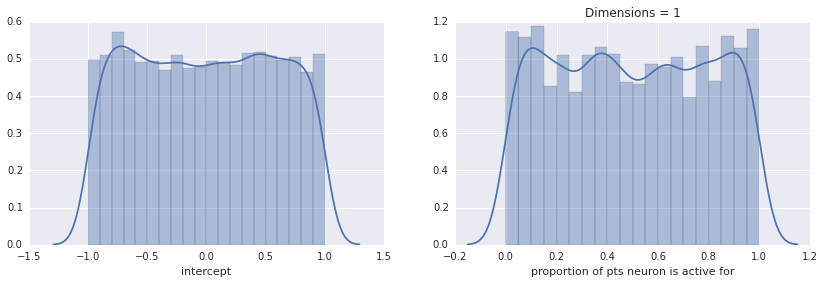

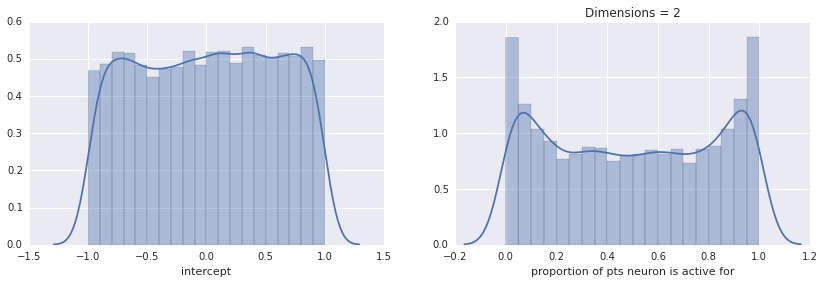

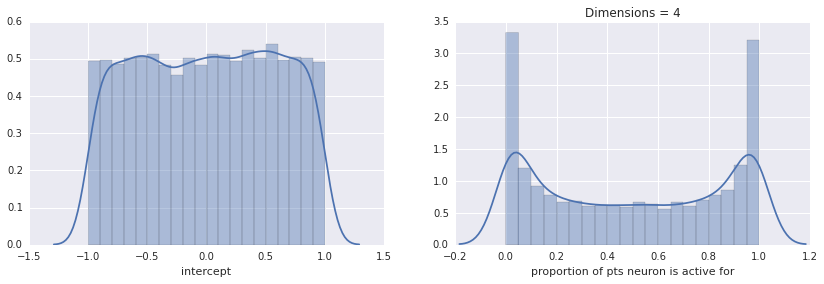

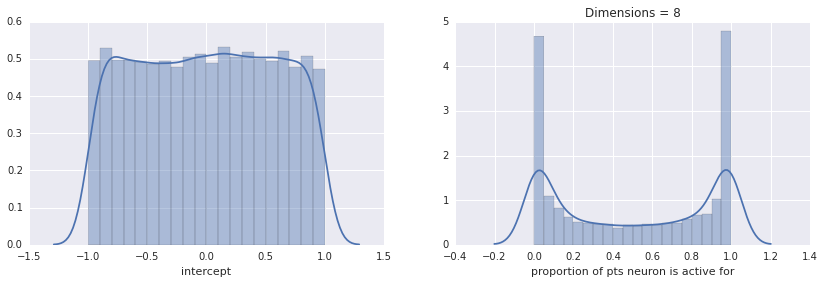

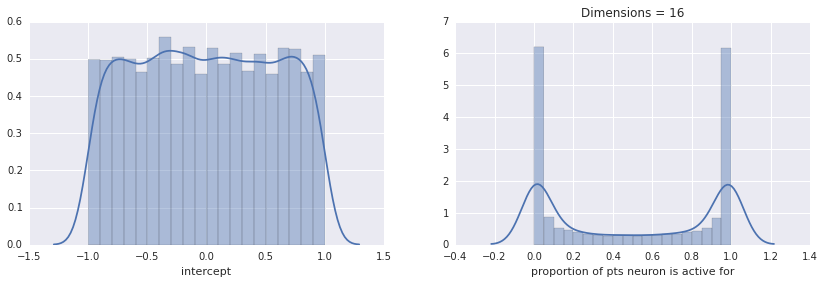

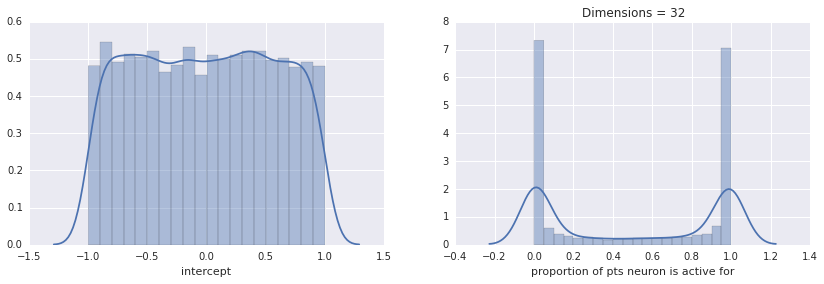

In [3]:
for D in [1, 2, 4, 8, 16, 32]:
    ens = nengo.Ensemble(n_neurons=10000, dimensions=D, add_to_container=False)
    pylab.figure(figsize=(14,4))   
    plot_intercept_distribution(ens)
    pylab.title('Dimensions = %d' % D)

Those peaks at 0% and 100% are very worrying!  It looks like a lot of these neurons aren't really helping much.

To understand this a bit better, let's see if we can directly compute this mapping from intercept to proportion active.  To do this, we need to compute the volume of a hyperspherical cap https://en.wikipedia.org/wiki/Spherical_cap#Hyperspherical_cap

<img src=https://upload.wikimedia.org/wikipedia/commons/thumb/2/2f/Spherical_cap_diagram.tiff/lossless-page1-220px-Spherical_cap_diagram.tiff.png>

The formula for the volume in general is $V = {1 \over 2} C_d r^d I_{2rh-h^2 \over r^2}({d+1 \over 2}, {1 \over 2})$ where $C_d$ is the volume of a unit hyperball of dimension $d$ and $I_x(a,b)$ is the regularized incomplete beta function.

In our case, if $x$ is the intercept, then $r=1$, $h=1-x$.  We want the proportion, so we divide by $C_d$, leaving:

$p={1 \over 2} I_{1-x^2}({d+1 \over 2}, {1 \over 2})$

Of course, this formula only works for $x>=0$.  For $x<0$ we can flip the sign of $x$ and then subtract 1 at the end.

In [49]:
import scipy.special
def analytic_proportion(x, d):
    flip = False
    if x < 0: 
        x = -x
        flip = True
        
    if x >= 1.0:
        value = 0
    else:
        value = 0.5 * scipy.special.betainc((d+1)/2.0, 0.5, 1 - x**2)
    
    if flip:
        value = 1.0 - value
    return value
    
print analytic_proportion(0.5, 2)



0.195501109478


This indicates an intercept of 0.5 in 2-dimensons only fires for 19.5% of the represented area.

Let's compare this analytic proportion to the empirically estimated proportion, just to check if it works.

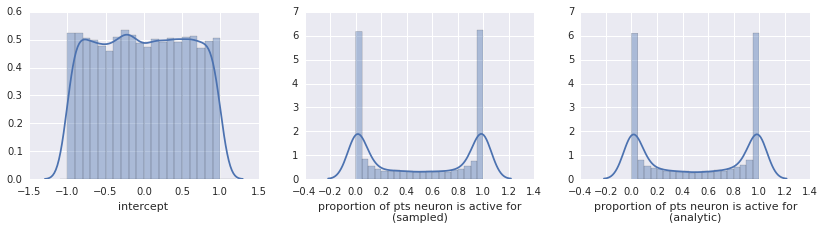

In [57]:
def plot_intercept_distribution(ens):
    pylab.subplot(1,3,1)
    intercepts = ens.intercepts
    if isinstance(intercepts, nengo.dists.Distribution):
        intercepts = intercepts.sample(ens.n_neurons)
    seaborn.distplot(intercepts, bins=np.linspace(-1.2, 1.2, 25))
    pylab.xlabel('intercept')
    pylab.xlim(-1.5, 1.5)

    pylab.subplot(1,3,2)
    pts = ens.eval_points.sample(n=1000, d=ens.dimensions)
    model = nengo.Network()
    model.ensembles.append(ens)
    sim = nengo.Simulator(model)
    _, activity = nengo.utils.ensemble.tuning_curves(ens, sim, inputs=pts)
    p = np.mean(activity>0, axis=0)
    seaborn.distplot(p, bins=20)
    pylab.xlabel('proportion of pts neuron is active for\n(sampled)')
    
    p2 = [analytic_proportion(x, ens.dimensions) for x in intercepts]
    pylab.subplot(1,3,3)
    seaborn.distplot(p2, bins=20)
    pylab.xlabel('proportion of pts neuron is active for\n(analytic)')
    
    
    
ens = nengo.Ensemble(n_neurons=10000, dimensions=16, add_to_container=False)
pylab.figure(figsize=(14,3))   
plot_intercept_distribution(ens)

Those look pretty similar to me!  This shows our analytic approach is working well.

Now, we need to reverse this effect.  What we want is a system that we can give an p value, and it will find the x-intercept value that gives that proportion.  Fortunately, ```scipy``` has an inverse for the beta function, so a bit of algebra on $p={1 \over 2} I_{1-x^2}({d+1 \over 2}, {1 \over 2})$ gives us

$x = \sqrt{1-I^{-1}_{2p}({d+1 \over 2}, {1 \over 2})}$

In [58]:
def find_x_for_p(p, d):
    sign = 1
    if p > 0.5:
        p = 1.0 - p
        sign = -1
    return sign * np.sqrt(1-scipy.special.betaincinv((d+1)/2.0, 0.5, 2*p))

print find_x_for_p(0.7, 2)


-0.319691509791


Let's see what happens when we apply this transformation to the intercepts

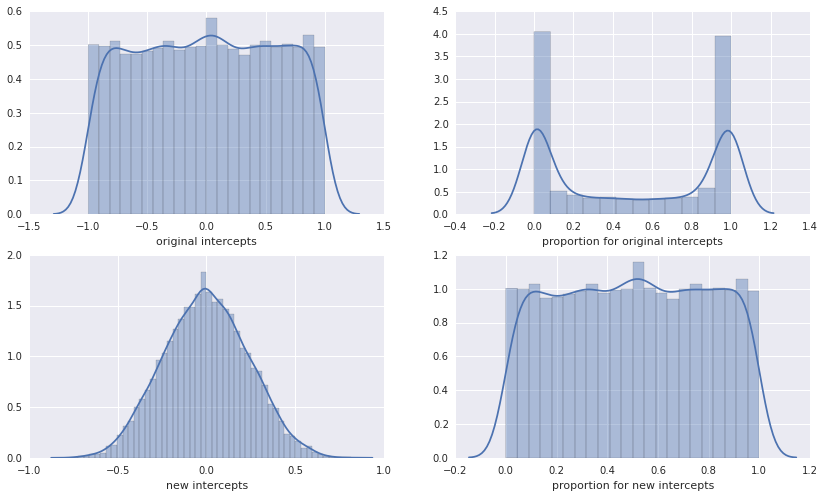

In [59]:
ens = nengo.Ensemble(n_neurons=10000, dimensions=16, add_to_container=False)
intercepts = ens.intercepts.sample(n=ens.n_neurons, d=1)[:,0]
intercepts2 = [find_x_for_p(x_int/2+0.5, ens.dimensions) for x_int in intercepts]
ens.intercepts = intercepts2

pylab.figure(figsize=(14,8))   
pylab.subplot(2, 2, 1)
seaborn.distplot(intercepts)
pylab.xlabel('original intercepts')
pylab.subplot(2, 2, 2)
seaborn.distplot([analytic_proportion(x, ens.dimensions) for x in intercepts])
pylab.xlabel('proportion for original intercepts')
pylab.subplot(2, 2, 3)
seaborn.distplot(intercepts2)
pylab.xlabel('new intercepts')
pylab.subplot(2, 2, 4)
seaborn.distplot([analytic_proportion(x, ens.dimensions) for x in intercepts2])
pylab.xlabel('proportion for new intercepts')



The new intercept distribution does what we want it to do!  It results in a uniform distribution of the proportion of the represented area that is active for each neuron.

Let's confirm this in multiple dimensions.

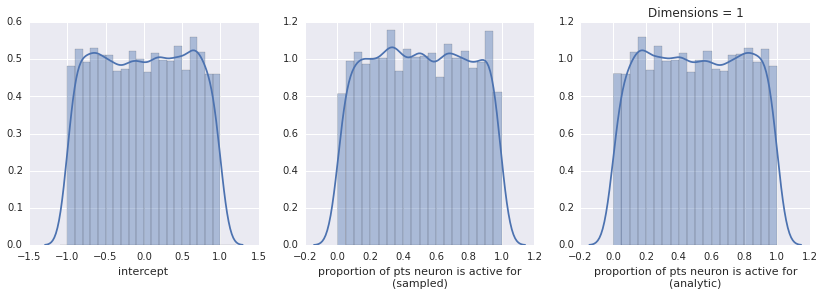

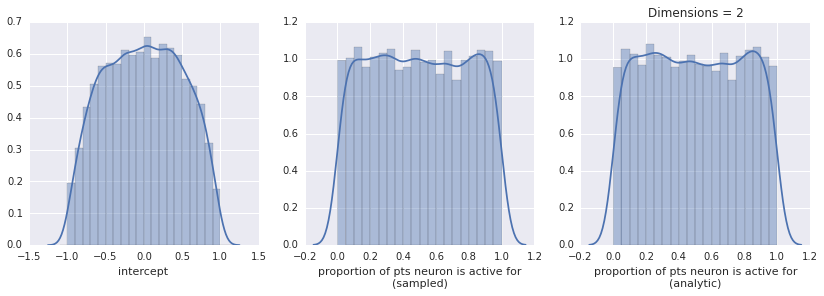

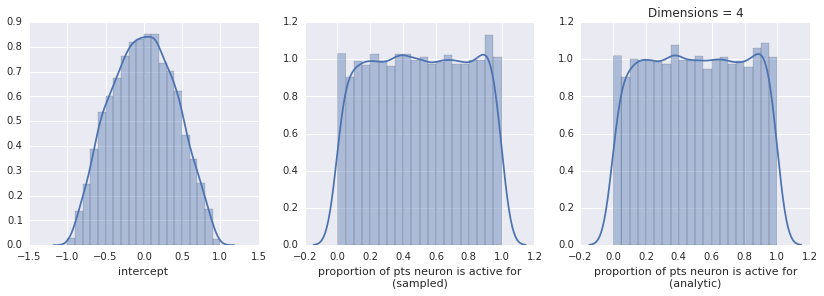

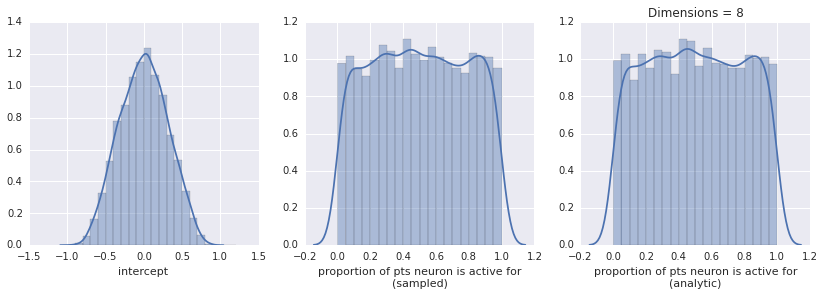

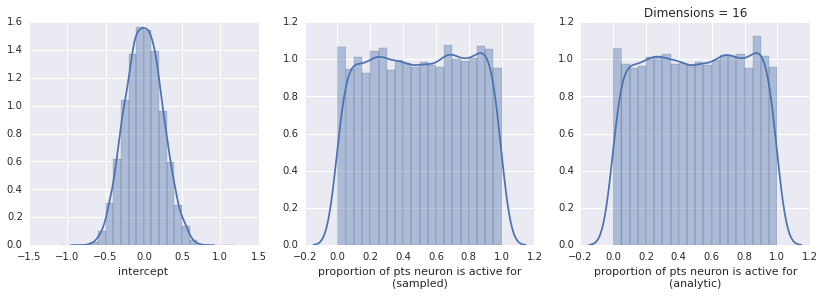

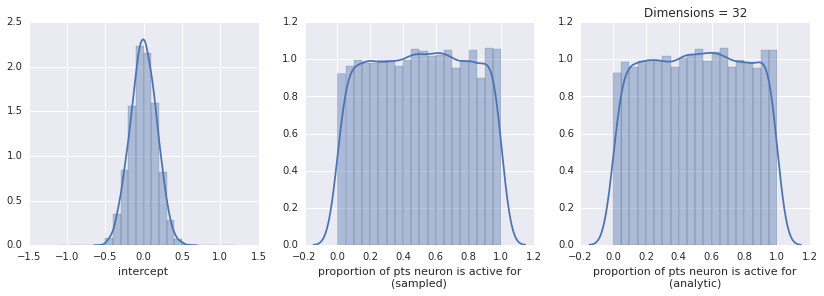

In [60]:
for D in [1, 2, 4, 8, 16, 32]:
    ens = nengo.Ensemble(n_neurons=10000, dimensions=D, add_to_container=False)
    intercepts = ens.intercepts.sample(n=ens.n_neurons, d=1)[:,0]
    intercepts2 = [find_x_for_p(x_int/2+0.5, ens.dimensions) for x_int in intercepts]
    ens.intercepts = intercepts2
    pylab.figure(figsize=(14,4))   
    plot_intercept_distribution(ens)
    pylab.title('Dimensions = %d' % D)

Okay, this formula works!  Now, does it improve decoder accuracy?  

To help check this, let's start by making a ```nengo.dists.Distribution``` that does this transformation for us.  It takes any intercept distribution and does the above transformation.  Note that we do a quick substitution of $p = {x_{intercept} + 1 \over 2}$ to turn an intercept into a desired probability.  This changes the $2p$ to $x+1$.


In [70]:
class AreaIntercepts(nengo.dists.Distribution):
    dimensions = nengo.params.NumberParam('dimensions')
    base = nengo.dists.DistributionParam('base')
    
    def __init__(self, dimensions, base=nengo.dists.Uniform(-1, 1)):
        super(AreaIntercepts, self).__init__()
        self.dimensions = dimensions
        self.base = base
        
    def __repr(self):
        return "AreaIntercepts(dimensions=%r, base=%r)" % (self.dimensions, self.base)
    
    def transform(self, x):
        sign = 1
        if x > 0:
            x = -x
            sign = -1
        return sign * np.sqrt(1-scipy.special.betaincinv((self.dimensions+1)/2.0, 0.5, x+1))
    
    def sample(self, n, d=None, rng=np.random):
        s = self.base.sample(n=n, d=d, rng=rng)
        for i in range(len(s)):
            s[i] = self.transform(s[i])
        return s

Now let's define a ```pytry.Trial``` to let us explore the accuracy of the system.  As we vary the number of dimensions, we will see how well we can decode a constant function ($1$), linear value ($x_i$), squared value ($x_i^2$), and other quadratic combinatons ($x_i y_i$).

In [73]:
class AreaInterceptTrial(pytry.Trial):
    def params(self):
        self.param('number of neurons per dimension', n_per_d=50)
        self.param('number of dimensions', d=1)
        self.param('use AreaIntercept distribution', use_area=False)
        
    def evaluate(self, p):
        model = nengo.Network(seed=p.seed)
        intercepts = nengo.dists.Uniform(-1, 1)
        if p.use_area:
            intercepts = AreaIntercepts(p.d, base=intercepts)
        n_neurons = p.n_per_d * p.d    
        with model:
            ens = nengo.Ensemble(n_neurons, p.d, intercepts=intercepts)

            def func_constant(x):
                return 1
            constant = nengo.Node(size_in=1)
            c_constant = nengo.Connection(ens, constant, function=func_constant)

            def func_linear(x):
                return x
            linear = nengo.Node(size_in=p.d)
            c_linear = nengo.Connection(ens, linear, function=func_linear)

            def func_square(x):
                return x**2
            square = nengo.Node(size_in=p.d)
            c_square = nengo.Connection(ens, square, function=func_square)

            def func_quad(x):
                r = []
                for i, xx in enumerate(x):
                    for j, yy in enumerate(x[i+1:]):
                        r.append(xx*yy)
                return r
            count = len(func_quad(np.zeros(p.d))) 
            if count > 0:
                quad = nengo.Node(size_in=count)
                c_quad = nengo.Connection(ens, quad, function=func_quad)
            else:
                c_quad = None

        sim = nengo.Simulator(model)
        return dict(
            constant = np.mean(sim.data[c_constant].solver_info['rmses']),
            linear = np.mean(sim.data[c_linear].solver_info['rmses']),
            square = np.mean(sim.data[c_square].solver_info['rmses']),
            quad = np.mean(sim.data[c_quad].solver_info['rmses']) if c_quad is not None else 0,
            )        

Now let's check to see how it performs

In [75]:
seed = 1
print AreaInterceptTrial().run(d=16, verbose=False, seed=seed)
print AreaInterceptTrial().run(d=16, verbose=False, use_area=True, seed=seed)


{'quad': 0.035350455046965774, 'square': 0.048417423128014378, 'constant': 0.0034552953061511549, 'linear': 0.014292580442933904}
{'quad': 0.026159405279848925, 'square': 0.03574972041237013, 'constant': 0.0073560990547019232, 'linear': 0.012546736700278584}


This looks like an improvement in all cases except for the constant!  Let's see if this holds up for other dimensions (and averaging over many runs with different seeds).

In [78]:
for seed in range(30, 40):   # be sure to change this range each time you run it
                             #  or it will re-generate the same data as before
                             #  (the data is being stored in the directory "decode2")
    print 'seed', seed
    for d in [1, 2, 4, 8, 16, 32]:
        AreaInterceptTrial().run(d=d, verbose=False, seed=seed, data_dir='decode2')
        AreaInterceptTrial().run(d=d, verbose=False, seed=seed, data_dir='decode2', use_area=True)        

seed 21
seed 22
seed 23
seed 24
seed 25
seed 26
seed 27
seed 28
seed 29


Now let's load up this data and plot it.

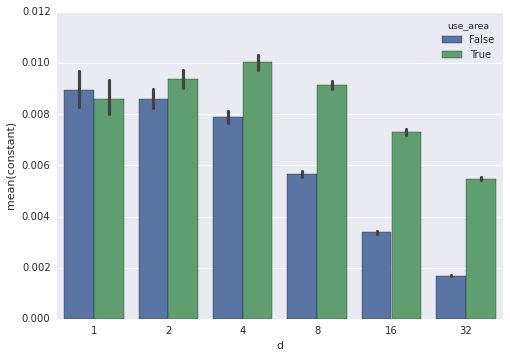

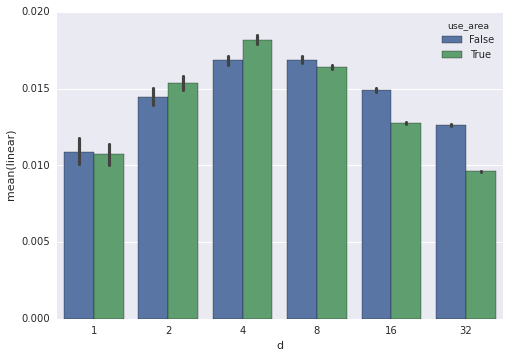

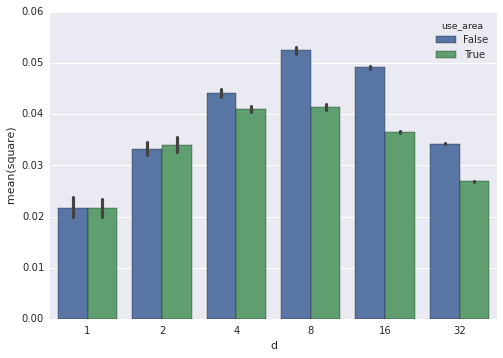

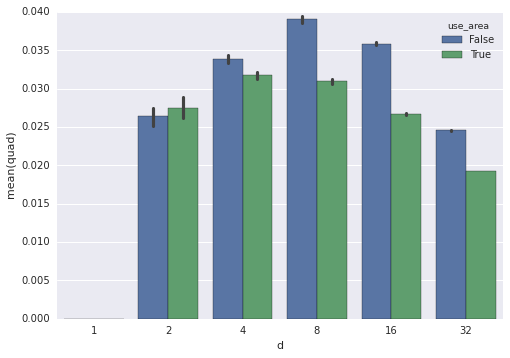

In [81]:
df = pandas.DataFrame(pytry.read('decode2'))
pylab.figure()
seaborn.barplot('d', 'constant', hue='use_area', data=df)
pylab.figure()
seaborn.barplot('d', 'linear', hue='use_area', data=df)
pylab.figure()
seaborn.barplot('d', 'square', hue='use_area', data=df)
pylab.figure()
seaborn.barplot('d', 'quad', hue='use_area', data=df)
pylab.show()

The result is consistent!  This intercept distribution usually improves things!  It does make the constant term a little bit worse, and it looks like the linear case in 2 and 4 dimensions seems to get a little bit worse as well.  But it can get a pretty big improvement at higher dimensions!